In [1]:
# !pip install numpy pandas neurokit2 pyplr seaborn

### Imports and helper functios

In [2]:
import numpy as np
import pandas as pd
import neurokit2 as nk
import plotly.express as px
from pyplr import preproc
import glob
from operator import itemgetter
import os
from util import plot_data, plot_channels, plot_gantt, markers_to_gantt, plot_correlation_matrix
from IPython.display import display

In [3]:
# Adapted from Neurokit's read_xdf() to work with the data from this experiment
# https://neuropsychology.github.io/NeuroKit/functions/data.html#neurokit2.data.read_xdf
def read_xdf(filename, upsample=2, fillmissing=None):
    """**Read and tidy an XDF file**"""

    def get_markers(markers_stream):
        markers = markers_stream['time_series']
        assert all(len(marker) == 1 for marker in markers), 'Warning: There is an event containing more than one marker'
        markers = [marker[0] for marker in markers]

        # Only keep unique markers occurring in expected order
        relevant_indices = []
        expected_marker_order = ['app-start', 'cookies-start', 'cookies-end', 'geolocation-start', 'geolocation-end', 'confirmshaming-start', 'confirmshaming-end', 'personalDetails-start', 'confusingCheckbox-start', 'confusingCheckbox-end', 'personalDetails-end', "creditCard-start", "creditCard-end", 'id-start', "cameraPermission-start", "cameraPermission-end", 'id-end', 'app-end']
        previous_index = 0
        for marker in expected_marker_order:
            if marker in markers[previous_index:]:
                index = markers.index(marker, previous_index)
                relevant_indices.append(index)
                previous_index = index
            else:
                print(f'Missing marker: {marker}')

        timestamps = itemgetter(*relevant_indices)(markers_stream['time_stamps'])
        markers = itemgetter(*relevant_indices)(markers)
        return markers, timestamps

    try:
        import pyxdf
    except ImportError:
        raise ImportError(
            "The 'pyxdf' module is required for this function to run. ",
            "Please install it first (`pip install pyxdf`).",
        )

    # Load file
    print(f"Reading file: {filename}")
    streams, header = pyxdf.load_xdf(filename)

    # Remove any empty streams
    streams = [stream for stream in streams if len(stream['time_series'])]

    # Process markers stream first
    markers_stream = next(filter(lambda stream: isinstance(stream['time_series'], list), streams))
    streams.remove(markers_stream)
    markers, timestamps = get_markers(markers_stream)

    # Get the smallest time stamp ('app-start') to later use as offset (zero point) as well as the largest timestamp ('app-end') to cut off data
    offset = min(timestamps)
    max_ts = max(timestamps) - offset

    markers_df = pd.DataFrame(markers, columns=['marker'])
    markers_df.index = pd.to_datetime(timestamps - offset, unit="s")

    # Process other streams and convert to dataframes
    dfs = []
    for stream in streams:
        channels_info = stream["info"]["desc"][0]["channels"][0]["channel"]
        cols = [channels_info[i]["label"][0] for i in range(len(channels_info))]
        dat = pd.DataFrame(stream["time_series"], columns=cols)

        # Get time stamps and offset from minimum time stamp
        dat.index = pd.to_datetime(stream["time_stamps"] - offset, unit="s")
        dfs.append(dat)

    # Store info of each stream ----------------------------------------------------------------
    # Store metadata
    info = {
        "sampling_rates_original": [float(s["info"]["nominal_srate"][0]) for s in streams],
        "sampling_rates_effective": [float(s["info"]["effective_srate"]) for s in streams],
        "datetime": header["info"]["datetime"][0],
        "data": dfs,
    }

    # Synchronize ------------------------------------------------------------------------------
    # Merge all dataframes by timestamps
    # Note: this is a critical steps, as it inserts timestamps and makes it non-evenly spread
    streams_df = dfs[0]
    for i in range(1, len(dfs)):
        streams_df = pd.merge(streams_df, dfs[i], how="outer", left_index=True, right_index=True)
    streams_df = streams_df.sort_index()

    # Resample and Interpolate -----------------------------------------------------------------
    # Final sampling rate will be 2 times the maximum sampling rate
    # (to minimize aliasing during interpolation)
    info["sampling_rate"] = int(np.max(info["sampling_rates_original"]) * upsample)

    if fillmissing is not None:
        fillmissing = int(info["sampling_rate"] * fillmissing)

    # Create new index with evenly spaced timestamps
    idx = pd.date_range(streams_df.index.min().floor(freq='s'), streams_df.index.max(), freq=str(1000 / info["sampling_rate"]) + "ms")
    streams_df = streams_df.reindex(streams_df.index.union(idx))

    # Interpolate numeric columns across the new index
    streams_df = streams_df.interpolate(method="index", limit=fillmissing)

    # Drop the old timestamp indices
    streams_df = streams_df.reindex(idx)

    # Cut off data before first marker and after last marker
    streams_df = streams_df[(streams_df.index >= pd.to_datetime(0)) & (streams_df.index <= pd.to_datetime(max_ts, unit='s'))]

    return streams_df, markers_df, info

In [4]:
def get_signals_and_events(streams_df, markers_df, info, plot=True):
    # Clean up the streams
    
    # Rename some columns for clarity
    rename_columns = {
        # 'RAW0': 'PPG',
        'EDABITREV1': 'EDA', 'ECGBIT2': 'ECG'}

    pupil_cols = ['left_pupil_diameter', 'right_pupil_diameter']
    pupil_validity_cols = ['left_pupil_validity', 'right_pupil_validity']
    # Keep only the columns we want
    columns_to_keep = [*rename_columns.values(),
                       *pupil_validity_cols,
                       *pupil_cols,
                       ]

    
    streams_df = streams_df.rename(columns=rename_columns)
    streams_df = streams_df[columns_to_keep]

    if plot:
        # Plot raw data except the left_pupil_validity and right_pupil_validity columns
        plot_data(streams_df.drop(columns=pupil_validity_cols), markers_df, title='Raw Channel Data', hide_end_markers=True)

    # Process pupil diameter
    samples = preproc.mask_pupil_first_derivative(streams_df, threshold=2.0, mask_cols=pupil_cols)

    # Mask pupil confidence threshold
    for pupil, pupil_validity in zip(pupil_cols, pupil_validity_cols):
        samples[pupil] = samples[pupil].mask(samples[pupil_validity] < 0.99)

    # Interpolate pupil samples
    samples = preproc.interpolate_pupil(samples, interp_cols=pupil_cols)

    # Smooth pupil data with Butterworth filter
    samples = preproc.butterworth_series(samples, fields=pupil_cols, filt_order=3, cutoff_freq=4/(info["sampling_rate"]/2))

    samples['pupil_diameter'] = samples[pupil_cols].mean(axis=1)
    
    # Process EDA and ECG
    signals, signals_info = nk.bio_process(eda=streams_df['EDA'], ecg=streams_df['ECG'], keep=samples,sampling_rate=info["sampling_rate"])

    if plot:
        # Plot EDA and ECG
        nk.eda_plot(signals, signals_info)
        nk.ecg_plot(signals, signals_info)

    # Reindex markers with numeric index for further processing
    markers_numindexed = markers_df.set_index(streams_df.index.get_indexer(markers_df.index, method='nearest'))
    # Remove the first and last marker and camera permission markers
    markers_to_remove = ['app-start', 'app-end', 'cameraPermission-start', 'cameraPermission-end']
    markers_df = markers_df[~markers_df.marker.isin(markers_to_remove)]
    markers_numindexed = markers_numindexed[~markers_numindexed.marker.isin(markers_to_remove)]
    
    if plot:
        # Plot processed signals (only some columns)
        columns_to_plot = ['EDA_Clean', 'EDA_Tonic', 'EDA_Phasic', 'ECG_Clean', 'ECG_Rate', 'pupil_diameter']
        plot_channels(signals[columns_to_plot], markers_numindexed, title='Processed Channel Data', hide_end_markers=True)
        plot_gantt(markers_df)
    

    # Create events dictionary from gantt data for event-related analysis
    gantt_data = markers_to_gantt(markers_numindexed)
    
    labels = [d['marker'] for d in gantt_data]
    events = dict(
        onset=[d['start'] for d in gantt_data],
        duration=[d['end'] - d['start'] for d in gantt_data],
        label=labels,
        condition=labels
    )

    return signals, events

In [5]:
def get_epoch_features(signals, events, plot=True):
    # Build epochs from events
    # Make epochs as long as their respective events duration + 1 second, but no longer than 5 seconds
    samples_to_seconds = lambda samples, sampling_rate: samples / sampling_rate
    epochs_end = [min(5, samples_to_seconds(duration, info["sampling_rate"])) for duration in events['duration']]
    epochs = nk.epochs_create(signals, events, sampling_rate=info["sampling_rate"], epochs_start=-1, epochs_end=epochs_end)

    if plot:
        # Plot epochs
        columns_to_plot = ['ECG_Rate', 'EDA_Tonic', 'EDA_Phasic', 'pupil_diameter']
        for epoch in epochs.values():
            nk.signal_plot(epoch[columns_to_plot],
                           title=epoch['Condition'].values[0],  # Extract condition name
                           standardize=True)
 
    # Analyze epochs and extract features
    bio_epoch_features = nk.bio_analyze(epochs, sampling_rate=info["sampling_rate"])
    
    # Analyze pupil diameter features too
    def pupil_analyze(epochs):
        from neurokit2.epochs.eventrelated_utils import (
            _eventrelated_rate,
            _eventrelated_sanitizeoutput
        )
        data = {}
        for i in epochs.keys():
            data[i] = {}
            data[i] = _eventrelated_rate(epochs[i], data[i], var="pupil_diameter")
    
        return _eventrelated_sanitizeoutput(data)

    pupil_epoch_features = pupil_analyze(epochs)

    epoch_features = pd.concat([bio_epoch_features, pupil_epoch_features], axis=1)
    for event in epochs.keys():
        epoch_features.loc[event, 'total_duration'] = samples_to_seconds(events['duration'][events['label'].index(event)], info["sampling_rate"])
    epoch_features = epoch_features.drop(columns=["Event_Onset", "Label", "Condition"])
    return epoch_features

In [6]:
def load_questionnaire(subject):
    file_results = glob.glob(f'data/{subject}/*questionnaire.json')
    if not file_results:
        raise FileNotFoundError(f"No questionnaire file found in directory {subject}")
    questionnaire_file = file_results[0]
    df = pd.read_json(questionnaire_file)
    df = df.rename(columns={'result': 'likert'})
    
    # Split answers into two parts
    is_iuipc_answer = df.index.str.startswith("iuipc")
    part1_answers_df = df[~is_iuipc_answer].copy()
    iuipc_answers = df[is_iuipc_answer]
    iuipc_score = iuipc_answers.likert.sum()

    # Map part1 answer keys to event conditions for later correlation analysis
    part1_answers_to_events = {"cookiesNoChoice": "cookies", "locationConcern": "geolocation", "notificationsConcern": "confirmshaming", "personalDetailsConcern": "personalDetails", "confusingCheckbox": "confusingCheckbox", "creditCardConcern": "creditCard", "idConcern": "id", "cameraConcern": "cameraPermission"}
    part1_answers_df.index = part1_answers_df.index.map(part1_answers_to_events)
    
    return part1_answers_df, iuipc_score


In [7]:
def load_demographics(subject):
    file_results = glob.glob(f'data/{subject}/*demographics.json')
    if not file_results:
        raise FileNotFoundError(f"No demographics file found in directory {subject}")
    demographics_file = file_results[0]
    demographics_df = pd.read_json(demographics_file, typ='series').to_frame().transpose()
    return demographics_df

### Load and process all data

In [8]:
if (os.path.isfile('interval_data.csv') and os.path.isfile('processed_epochs.csv') and os.path.isfile('metadata.csv')):
    # Processed data hasn't been saved yet, so process raw data
    dfs = []
    interval_dfs = []
    meta_dfs = []
    for i, subject in enumerate(sorted(os.listdir('data'))[:], start=1):
        # Read and clean subject's XDF file and extract streams and markers as dataframes
        streams_df, markers_df, info = read_xdf(f'data/{subject}/{subject}.xdf', upsample=2)
        
        # Further process the streams and markers
        signals, events = get_signals_and_events(streams_df, markers_df, info, plot=False)

        # Do interval analysis to get features about the whole signal
        interval_features =  nk.bio_analyze(signals, sampling_rate=info["sampling_rate"], method="interval")
        interval_features.index = [i]
    
        # Do event-related analysis to get features about epochs surrounding the events
        epoch_features = get_epoch_features(signals, events, plot=False)
        
        # Load subject's questionnaire answers
        part1_answers, iuipc_score = load_questionnaire(subject)
        df = epoch_features.join(part1_answers)
        df.insert(0, 'subject', i)

        # Load subject's demographics
        meta_df = load_demographics(subject)
        meta_df.index = [i]
        meta_df['iuipc'] = iuipc_score
    
        interval_dfs.append(interval_features)
        dfs.append(df)
        meta_dfs.append(meta_df)
        
        
    interval_df = pd.concat(interval_dfs)
    interval_df.to_csv('interval_data.csv')
    
    df = pd.concat(dfs)
    df.to_csv('processed_epochs.csv')
    
    meta_df = pd.concat(meta_dfs)
    meta_df.to_csv('metadata.csv')
else:
    # Processed data has already been saved, so load it
    df = pd.read_csv('processed_epochs.csv', index_col=0)
    interval_df = pd.read_csv('interval_data.csv', index_col=0)
    meta_df = pd.read_csv('metadata.csv', index_col=0)

Stream 3: Calculated effective sampling rate 59.9629 Hz is different from specified rate 90.0000 Hz.


Reading file: data/sub-001/sub-001.xdf
Missing marker: confusingCheckbox-end


Stream 2: Calculated effective sampling rate 59.9578 Hz is different from specified rate 90.0000 Hz.


Reading file: data/sub-002/sub-002.xdf
Missing marker: confusingCheckbox-end


Stream 2: Calculated effective sampling rate 59.8469 Hz is different from specified rate 90.0000 Hz.


Reading file: data/sub-003/sub-003.xdf
Missing marker: confusingCheckbox-end


Stream 1: Calculated effective sampling rate 59.7853 Hz is different from specified rate 90.0000 Hz.


Reading file: data/sub-004/sub-004.xdf
Missing marker: confusingCheckbox-end


Stream 2: Calculated effective sampling rate 58.3333 Hz is different from specified rate 90.0000 Hz.


Reading file: data/sub-005/sub-005.xdf
Missing marker: confusingCheckbox-end


Stream 3: Calculated effective sampling rate 59.0104 Hz is different from specified rate 90.0000 Hz.


Reading file: data/sub-006/sub-006.xdf
Missing marker: confusingCheckbox-end


found likely XDF file corruption (unpack requires a buffer of 8 bytes), scanning forward to next boundary chunk.
Stream 3: Calculated effective sampling rate 59.7969 Hz is different from specified rate 90.0000 Hz.


Reading file: data/sub-007/sub-007.xdf
Missing marker: confusingCheckbox-end


Stream 2: Calculated effective sampling rate 59.8323 Hz is different from specified rate 90.0000 Hz.


Reading file: data/sub-008/sub-008.xdf
Missing marker: confusingCheckbox-end


### Data Analysis

In [9]:
print('processed_epochs.csv')
display(df)
print('interval_data.csv')
display(interval_df)
print('metadata.csv')
display(meta_df)

# Print age range, mean and SD
print(f"Age range: {meta_df.age.min()} - {meta_df.age.max()}")
print(f"Mean age: {meta_df.age.mean():.1f}")
print(f"SD: {meta_df.age.std():.1f}")

processed_epochs.csv


subject  ECG_Rate_Baseline  ECG_Rate_Max  ECG_Rate_Min  \
cookies                  1          89.697477      2.610215     -0.145239   
geolocation              1          88.995315     -0.015418     -8.995315   
confirmshaming           1          76.433121      3.566879     -1.433121   
personalDetails          1          83.993821      4.241473     -8.522123   
confusingCheckbox        1          85.106383      0.000000     -8.673262   
creditCard               1          81.632653      2.283431    -20.808587   
id                       1          80.389805      7.845489      0.040320   
cookies                  2          90.560332      0.348759    -12.128960   
geolocation              2          73.619632      9.713701     -0.709889   
confirmshaming           2          85.340320      0.373966     -7.920965   
personalDetails          2          81.013812      7.221482      0.023250   
confusingCheckbox        2          85.764095      6.543598     -3.368939   
creditCard               2          83.500700     11.737395      0.021916   
id                       2          76.803835      7.112249      0.005924   
cookies                  3          81.963778      6.271516     -6.913562   
geolocation              3          76.538604     -0.117179    -19.666566   
confirmshaming           3          75.000000      0.000000     -7.203470   
personalDetails          3          81.249807     -0.006391     -6.869408   
confusingCheckbox        3          65.217391     16.974390      0.000000   
creditCard               3          73.314592      9.444029      0.016915   
id                       3          63.027236     13.385493     -0.200011   
cookies                  4          96.774194      0.000000     -7.221955   
geolocation              4          92.814139      4.746837     -2.588575   
confirmshaming           4          92.980341      0.042915     -4.745047   
personalDetails          4          89.867912      2.439781     -1.575331   
confusingCheckbox        4          89.957113      6.042887     -0.404874   
creditCard               4          90.750911      6.023283     -7.992290   
id                       4          86.673682      7.076318     -0.342747   
cookies                  5          60.275419      7.781780     -2.583111   
geolocation              5          64.140051      1.433720     -1.120609   
confirmshaming           5          59.294050     -0.006746     -4.811241   
personalDetails          5          61.656023      7.309494     -4.907749   
confusingCheckbox        5          57.695835      4.804165     -3.397192   
creditCard               5          71.227788      1.061369    -16.929145   
id                       5          57.416268      2.885240     -1.341502   
cookies                  6          80.380312     -0.016579     -5.380312   
geolocation              6          76.602805      9.728130     -1.131107   
confirmshaming           6          76.192486      5.872769     -0.720788   
personalDetails          6          80.000000      9.552239     -3.566879   
confusingCheckbox        6          83.668040      4.567254     -8.196342   
creditCard               6          73.003963     17.905128     -7.786572   
id                       6          73.551126      8.640654     -4.585609   
cookies                  7          43.419023     26.756415     -1.607177   
geolocation              7          82.144513     19.550402     -7.610352   
confirmshaming           7          81.041441     15.732753     -6.164742   
personalDetails          7          85.769880     11.791096     -6.299681   
confusingCheckbox        7          61.636466     29.272625    -15.591423   
creditCard               7          88.687513      9.673143    -45.209252   
id                       7          63.115321     26.436918    -21.157279   
cookies                  8          87.210763     15.353339     -4.950480   
geolocation              8          84.887624      8.135632    -13.459053   
confirmshaming 

interval_data.csv


ECG_Rate_Mean              HRV_MeanNN                HRV_SDNN  \
1     81.174973    [[739.397705544933]]  [[53.545470297322126]]   
2     82.599751               [[726.5]]   [[41.47847063038687]]   
3     74.585361   [[804.7128378378378]]    [[72.8651085089501]]   
4      93.02211   [[645.0691244239631]]   [[36.94756056310294]]   
5      59.74237  [[1004.6162790697674]]   [[71.56527797586921]]   
6     83.381822   [[720.2777777777778]]    [[66.2996230685667]]   
7      73.12186               [[835.0]]   [[358.5612311204113]]   
8     83.905135   [[716.1966463414634]]   [[67.13249554575975]]   

               HRV_SDANN1              HRV_SDNNI1               HRV_SDANN2  \
1  [[21.217726453709766]]   [[49.19378957121921]]    [[7.358073524404864]]   
2   [[6.504483964163621]]   [[40.86117855517176]]                  [[nan]]   
3  [[10.482339322296959]]   [[72.02496098729142]]                  [[nan]]   
4   [[15.75121838903927]]  [[34.259411038583494]]                  [[nan]]   
5   [[34.44887467888015]]   [[60.84061278164141]]    [[28.18456683248659]]   
6   [[16.21380204038523]]   [[64.38533964269678]]  [[0.46868295110811276]]   
7  [[119.79747207915638]]  [[316.34383994146907]]                  [[nan]]   
8  [[17.416975643413615]]    [[64.7747730264124]]   [[14.821139712281115]]   

              HRV_SDNNI2 HRV_SDANN5 HRV_SDNNI5               HRV_RMSSD  ...  \
1  [[53.28842145822977]]    [[nan]]    [[nan]]   [[37.31210911473698]]  ...   
2                [[nan]]    [[nan]]    [[nan]]   [[24.47317245909827]]  ...   
3                [[nan]]    [[nan]]    [[nan]]   [[44.12136574556863]]  ...   
4                [[nan]]    [[nan]]    [[nan]]   [[18.64026781716432]]  ...   
5  [[69.17815342771085]]    [[nan]]    [[nan]]    [[48.3076050806155]]  ...   
6  [[66.74380440620905]]    [[nan]]    [[nan]]   [[65.74967126874938]]  ...   
7                [[nan]]    [[nan]]    [[nan]]  [[425.64946374498646]]  ...   
8  [[66.07178270716129]]    [[nan]]    [[nan]]    [[82.7412041864814]]  ...   

                   HRV_CD                 HRV_HFD                 HRV_KFD  \
1  [[1.1742737279544508]]  [[1.6906531604595731]]  [[2.0727691643030224]]   
2   [[1.805227947407021]]   [[1.663717555036965]]  [[2.5196202984154255]]   
3  [[1.6179484113792137]]  [[1.6076674930542518]]  [[2.2831074655899495]]   
4   [[1.373673470414082]]  [[1.6189578427195745]]  [[2.4696548441849946]]   
5  [[1.7328632280718619]]   [[1.774080810626539]]   [[3.311927713728307]]   
6  [[1.7604638398288002]]  [[1.7970390617527168]]  [[4.1712436324190225]]   
7  [[0.8210388783092704]]  [[1.9343227969502683]]   [[2.779324733803512]]   
8  [[1.8334104264416355]]  [[1.9118260883934175]]   [[4.898580117760534]]   

                  HRV_LZC SCR_Peaks_N SCR_Peaks_Amplitude_Mean EDA_Tonic_SD  \
1  [[0.6906819989481409]]        35.0                 0.556439     1.022437   
2   [[0.735222255191299]]        31.0                 0.613409     1.319026   
3  [[0.7765699129649006]]        30.0                 0.171489     0.507923   
4  [[0.7267646183594498]]       378.0                 0.033488     0.367302   
5  [[0.7934407468232301]]        44.0                 0.356711     0.700382   
6  [[0.8150121430386461]]        35.0                 0.122605     1.062633   
7   [[0.723114744916879]]        32.0                 0.812620     0.515452   
8  [[0.9842547078028168]]        76.0                 0.135601     1.133892   

  EDA_Sympathetic EDA_SympatheticN EDA_Autocorrelation  
1        0.017225         0.000195            0.742880  
2             NaN              NaN           -0.045787  
3             NaN              NaN            0.382557  
4             NaN              NaN            0.544873  
5        0.028970         0.000859            0.639043  
6        0.043473         0.000641            0.778454  
7             NaN              NaN            0.067767  
8        0.076420         0.001547            0.797019  

[8 rows x 98 columns]

metadata.csv


age  gender  country                                    education  \
1  28  Female  Germany  Secondary education (Realschule, Gymnasium)   
2  31    Male     Iraq                            Bachelor's degree   
3  41    Male     Iraq                              Master's degree   
4  33  Female     Iraq                              Master's degree   
5  37    Male     Iraq                              Master's degree   
6  40  Female     Iraq                              Master's degree   
7  38  Female     Iraq                              Master's degree   
8  37    Male     Iraq                            Bachelor's degree   

                         profession englishSpeakingFrequency  \
1                           Student      A few times a month   
2  Manager in the catering industry                Every day   
3                      Program Lead                Every day   
4                         housewife      A few times a month   
5                     Social worker                Every day   
6                          Lecturer       A few times a week   
7                       Interpreter       A few times a week   
8                                 .      A few times a month   

  englishUnderstandingFrequency       englishProficiency  iuipc  
1                     Every day  Upper-Intermediate (B2)     37  
2                     Every day      Native Speaker (C2)     67  
3                     Every day            Advanced (C1)     55  
4            A few times a year            Advanced (C1)     55  
5                     Every day            Advanced (C1)     70  
6                     Every day            Advanced (C1)     66  
7            A few times a week            Advanced (C1)     70  
8                     Every day  Upper-Intermediate (B2)     30

Age range: 28 - 41
Mean age: 35.6
SD: 4.5


In [10]:
# Boxplot for Privacy Dark Patterns Questions likert scores
fig = px.box(df, x='subject', y='likert', points='all')
fig.update_layout(title='Privacy Dark Patterns Questions Likert Scores by Participant', title_x=0.5)
fig.show()

# Bar plot for IUIPC-10 scores
fig = px.bar(meta_df, x=meta_df.index, y='iuipc')
fig.update_layout(title='IUIPC-10 Scores by Participant', title_x=0.5, xaxis_title="subject")
fig.show()

#### Group by event and correlate across participants

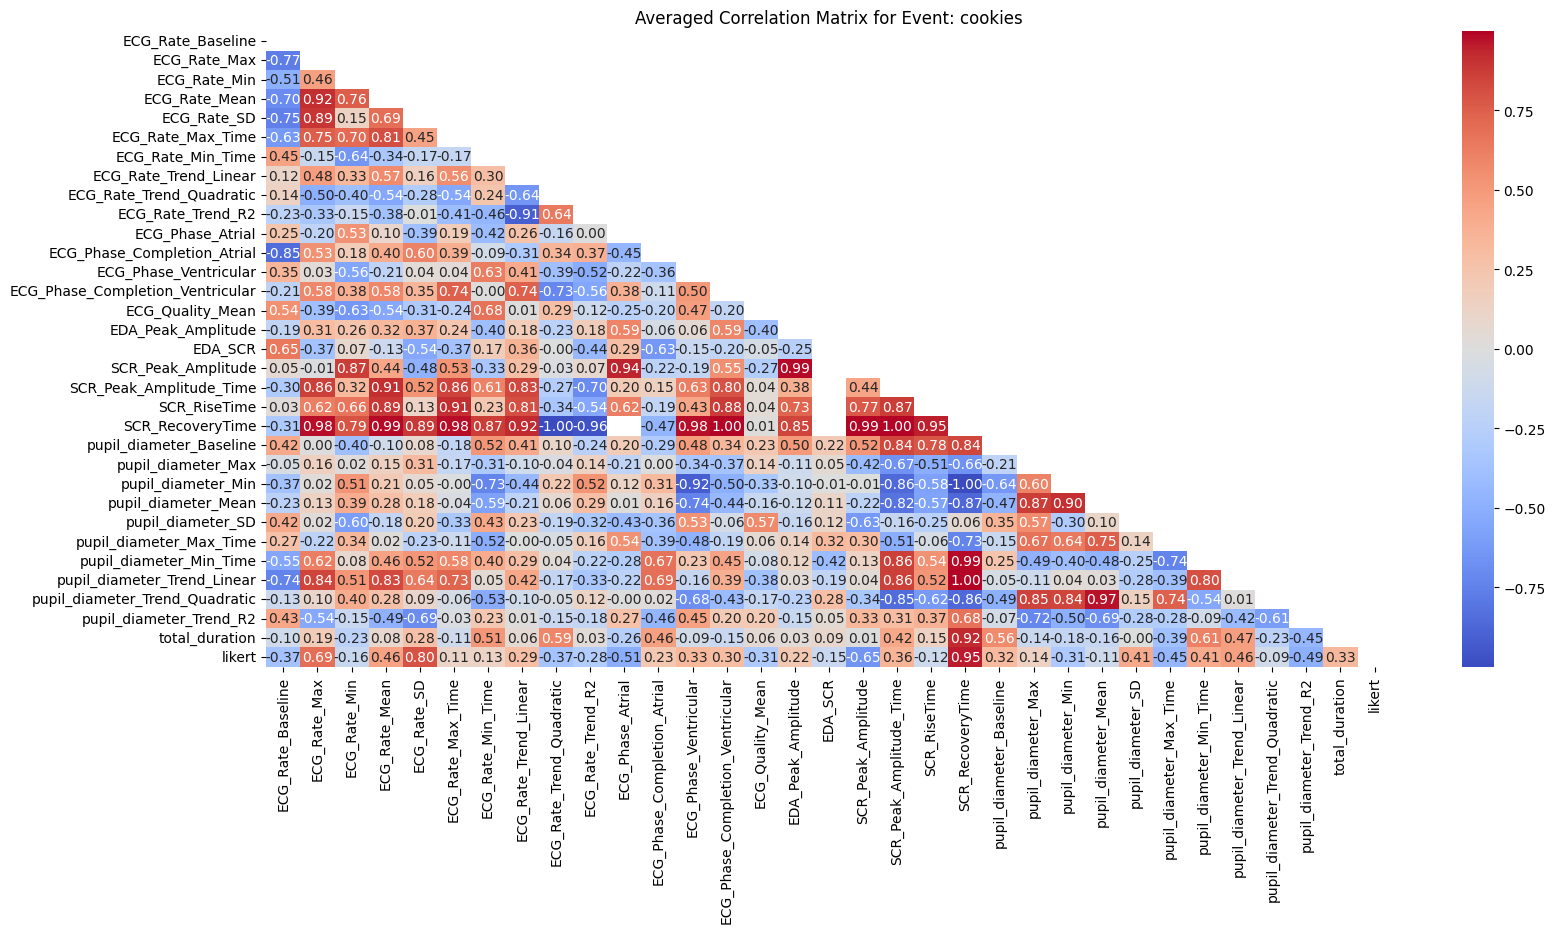

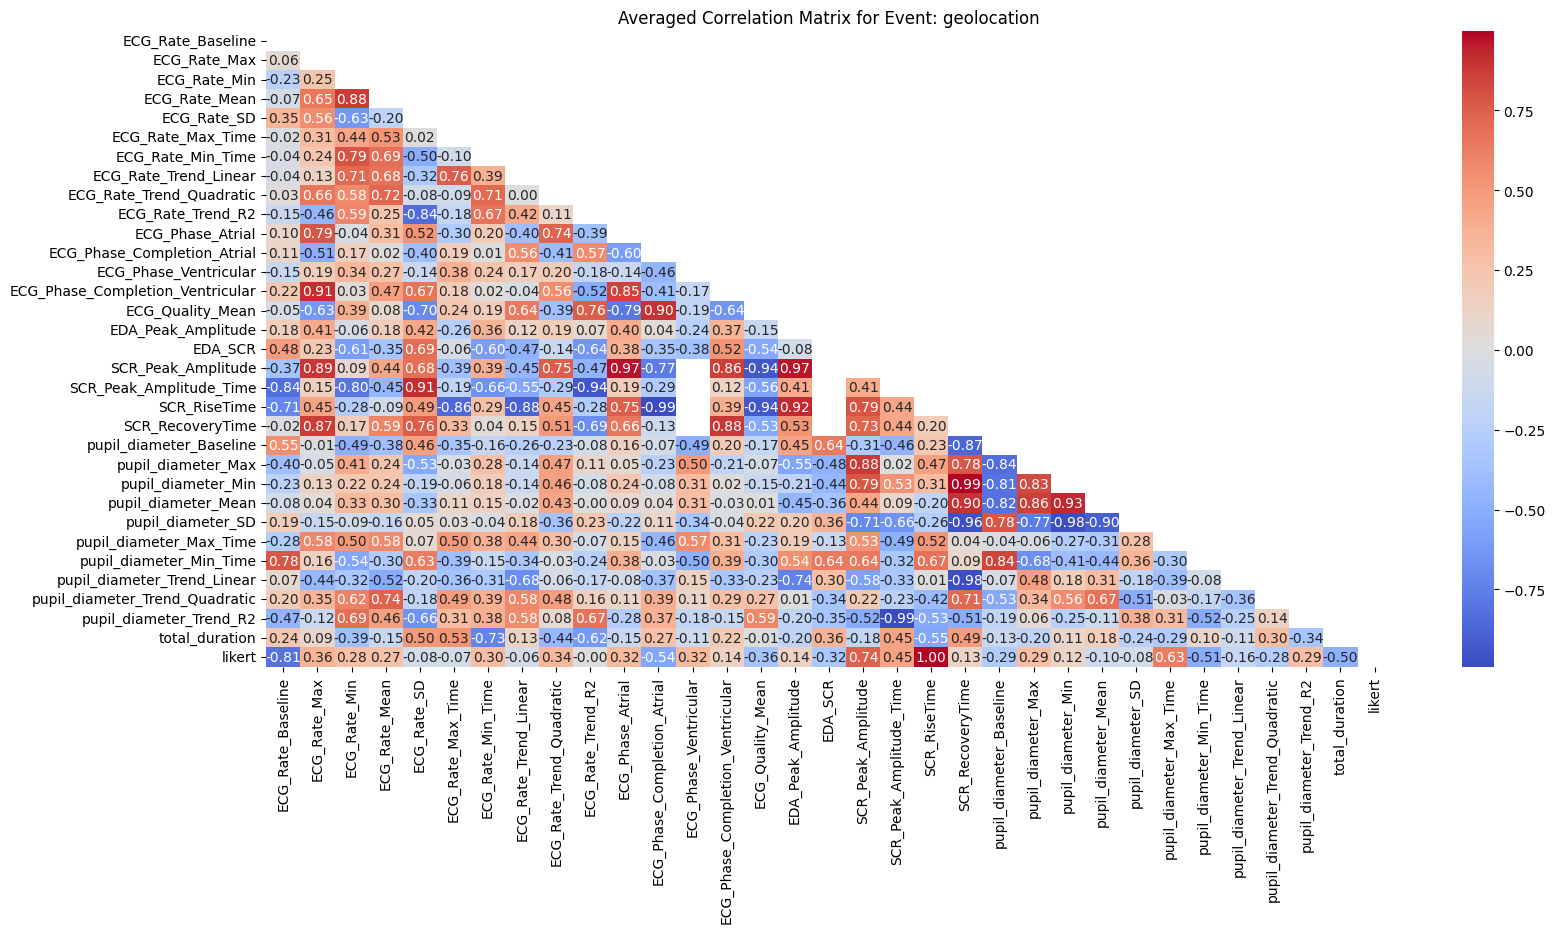

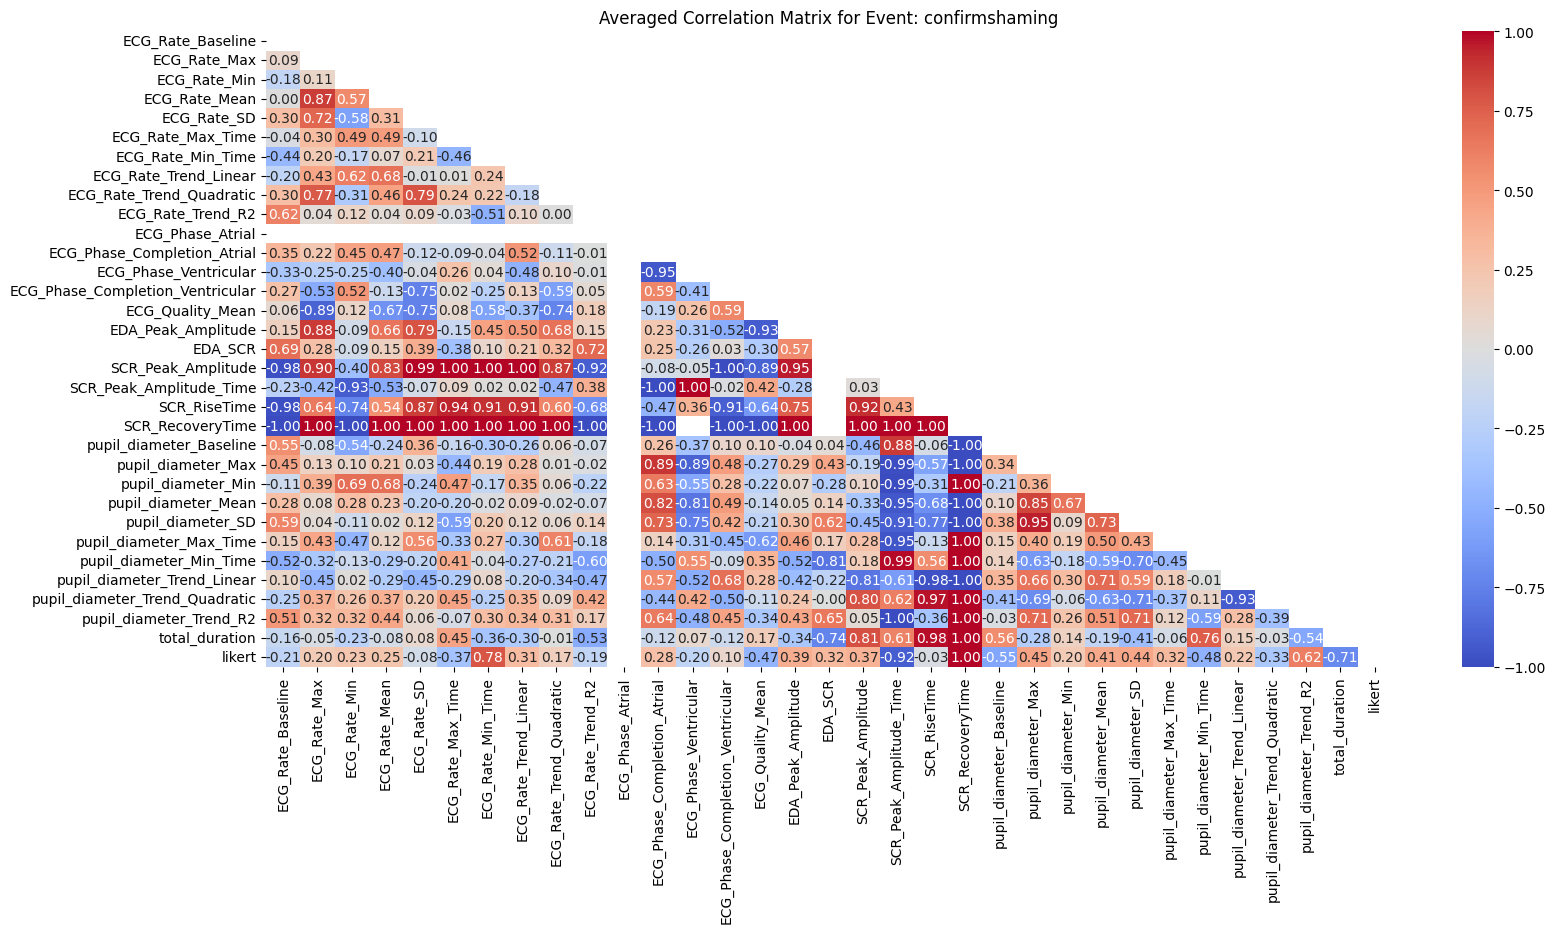

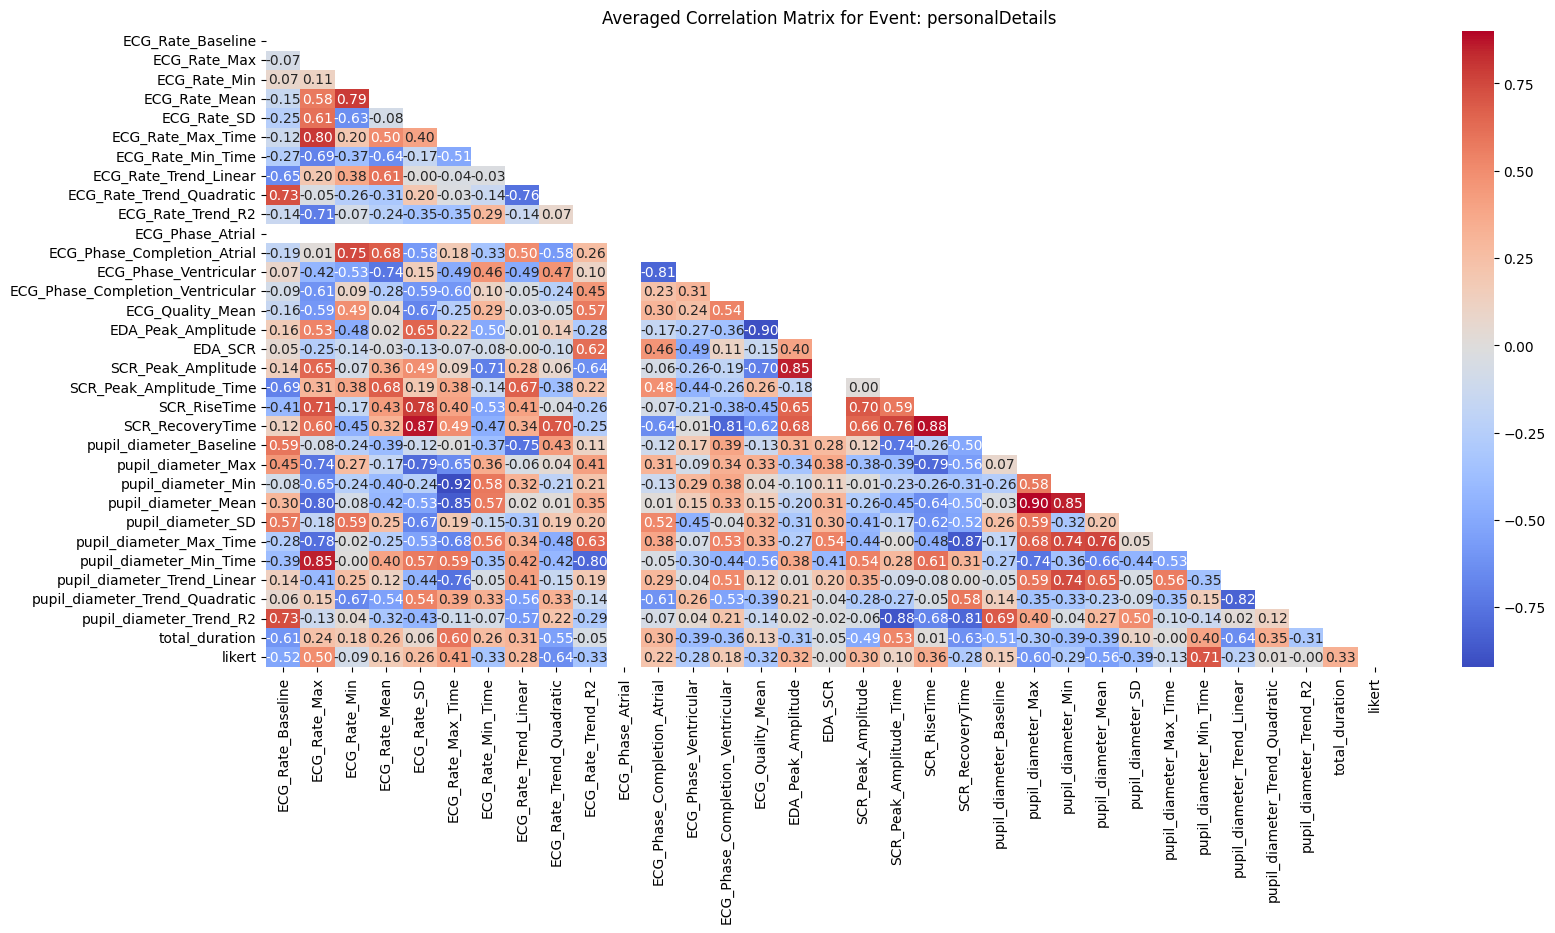

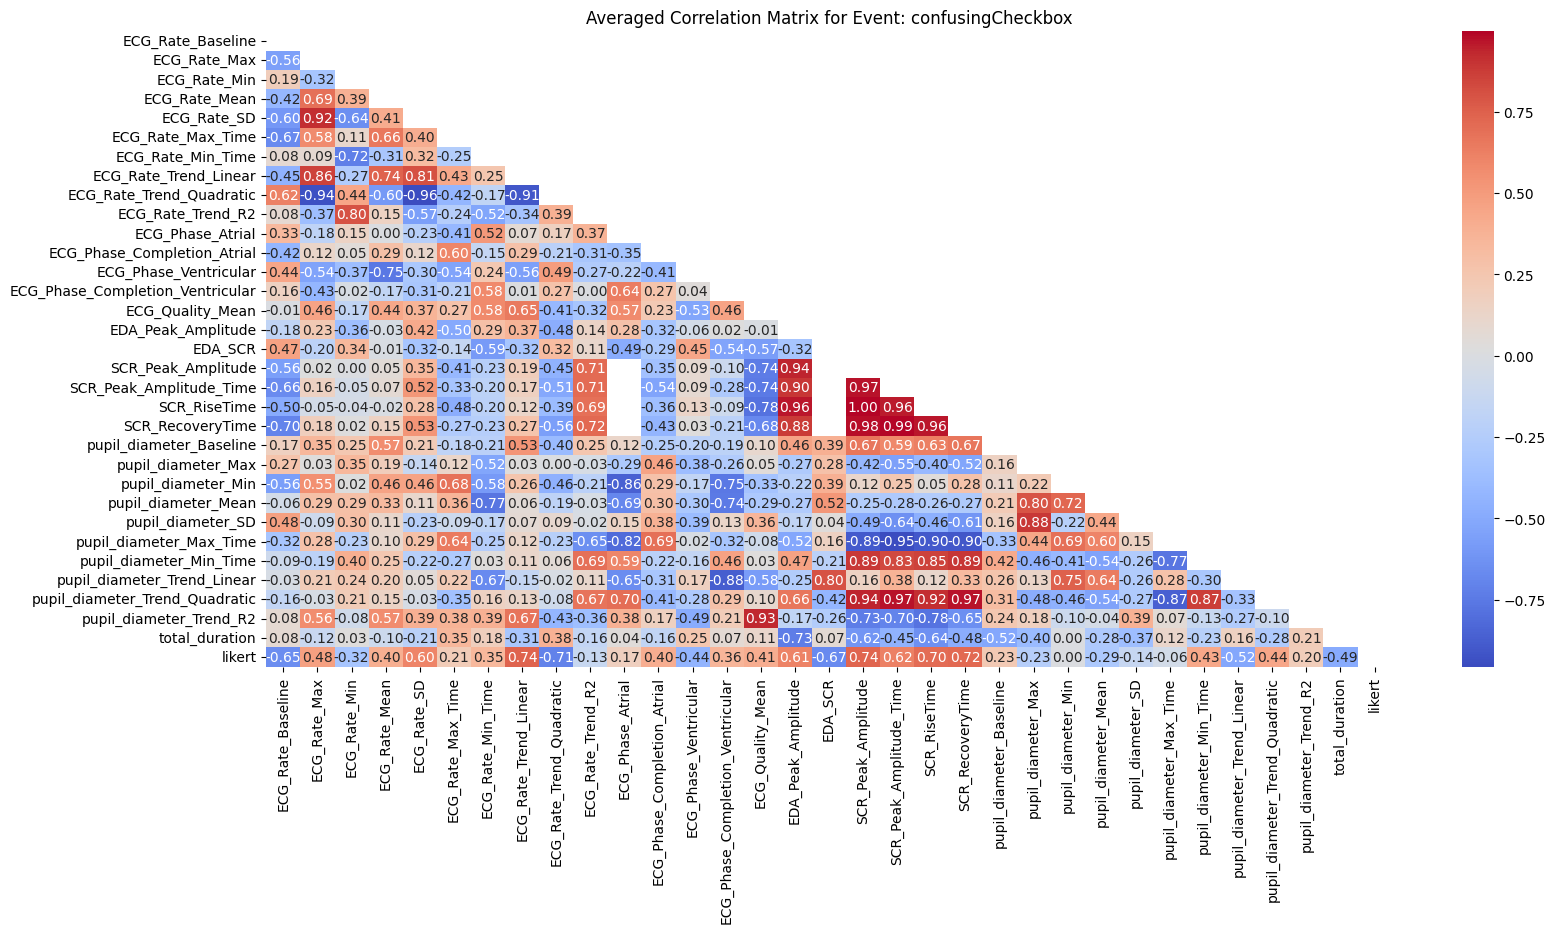

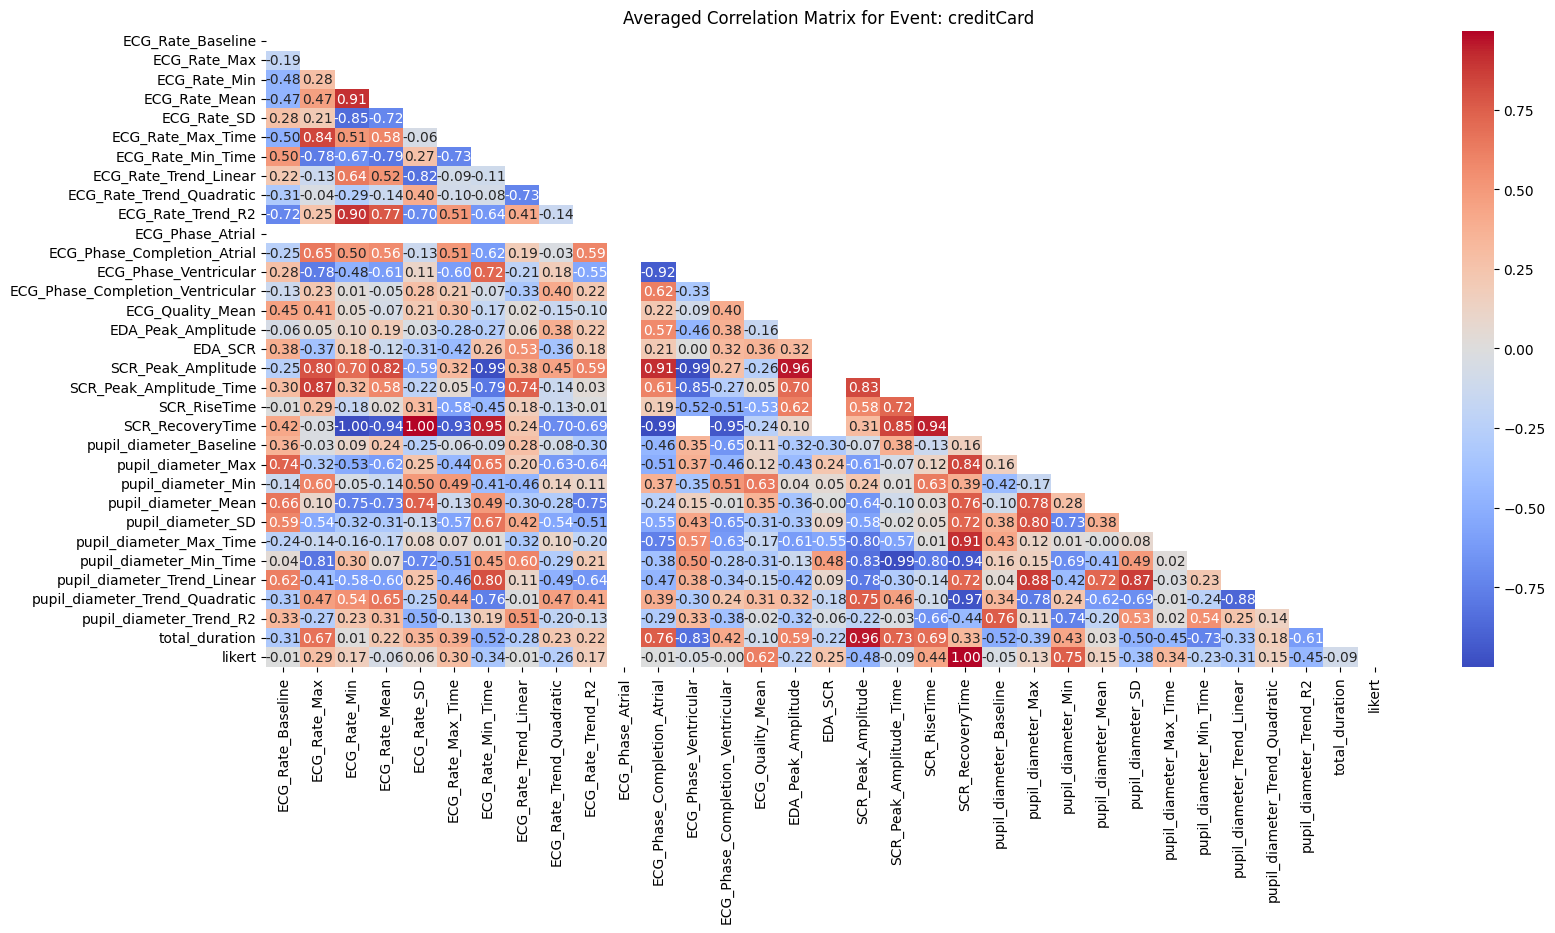

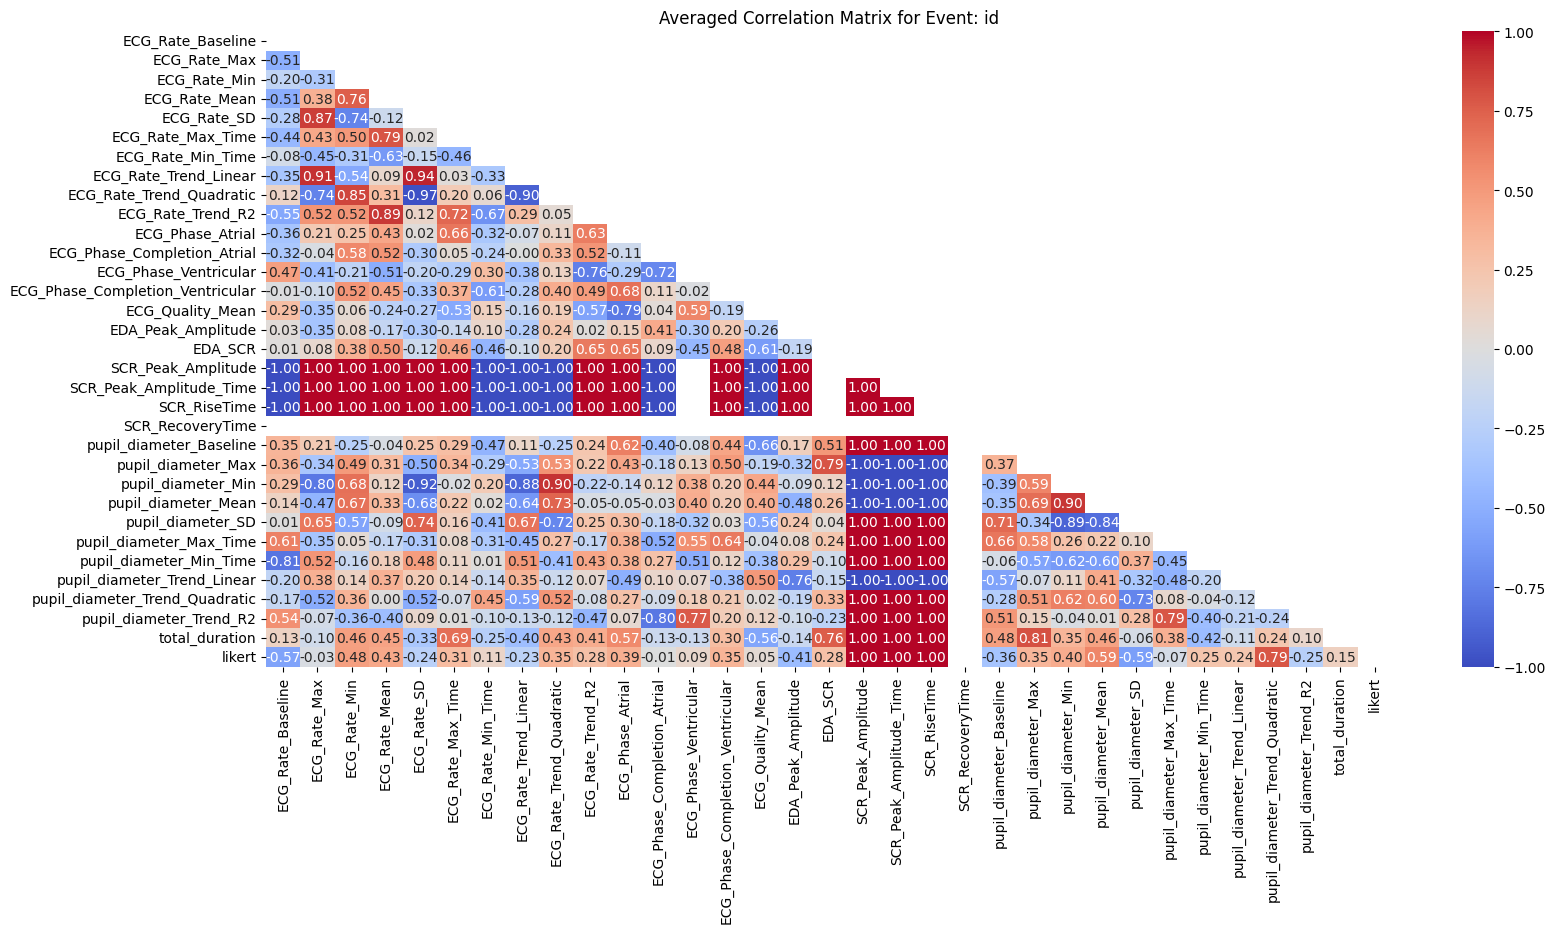

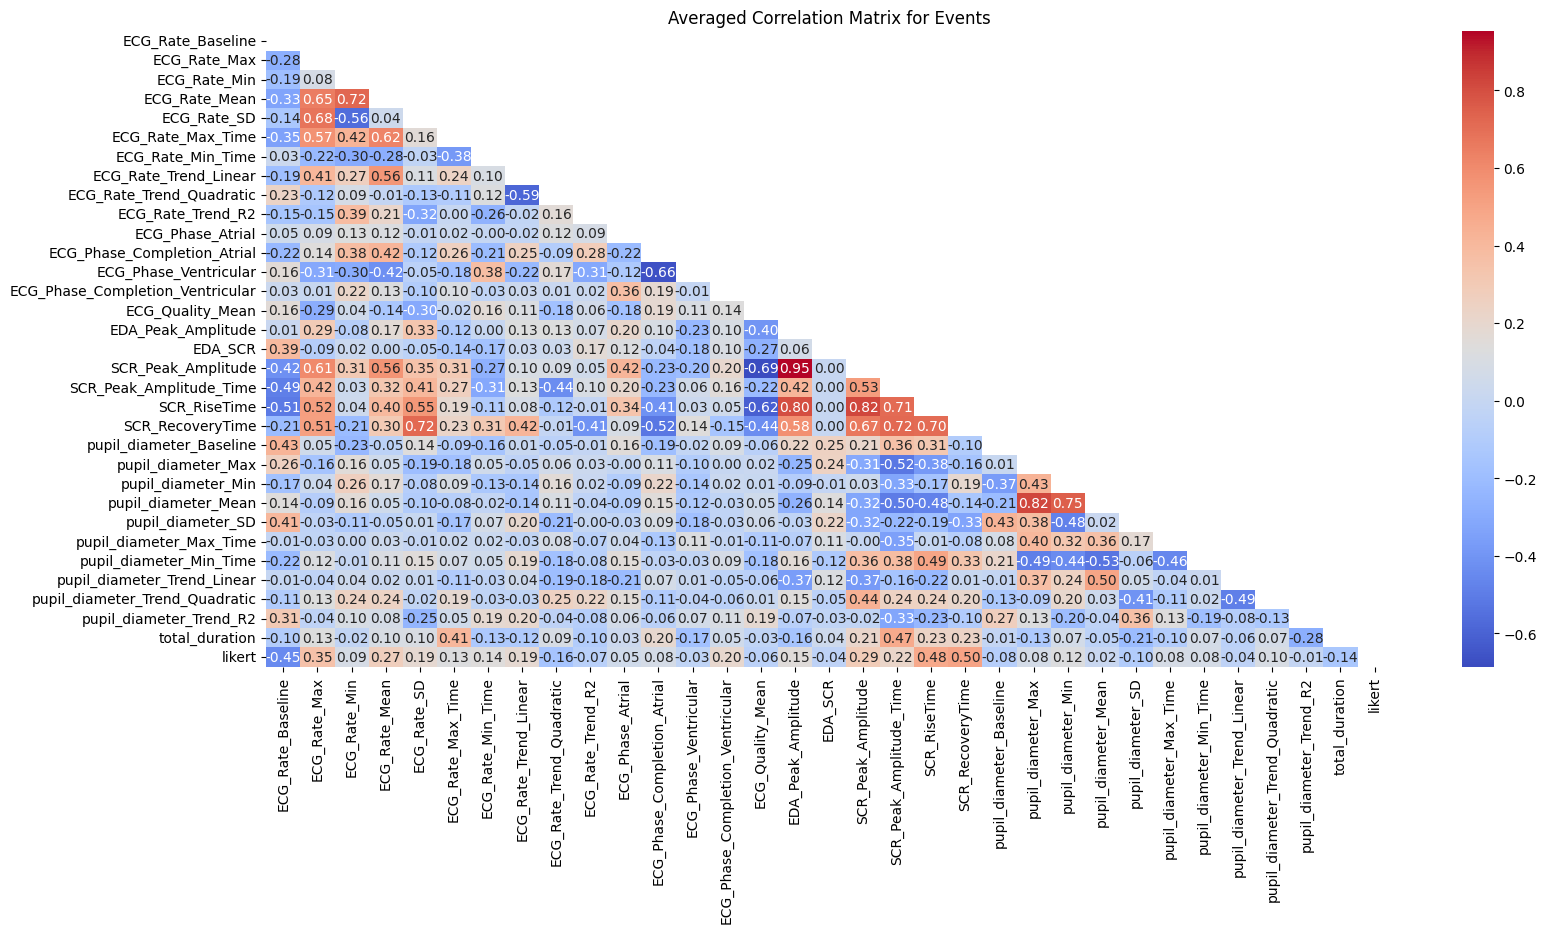

In [11]:
correlation_matrices = []
modified_df = df.drop(columns='subject')

for event in df.index.unique():
    correlation_matrix = modified_df[df.index == event].corr()
    plot_correlation_matrix(correlation_matrix, title=f"Averaged Correlation Matrix for Event: {event}")
    correlation_matrices.append(correlation_matrix)

average_correlation_matrix = pd.concat(correlation_matrices).groupby(level=0, sort=False).sum() / len(correlation_matrices)
plot_correlation_matrix(average_correlation_matrix, title="Averaged Correlation Matrix for Events")

#### Group by participant and correlate across events

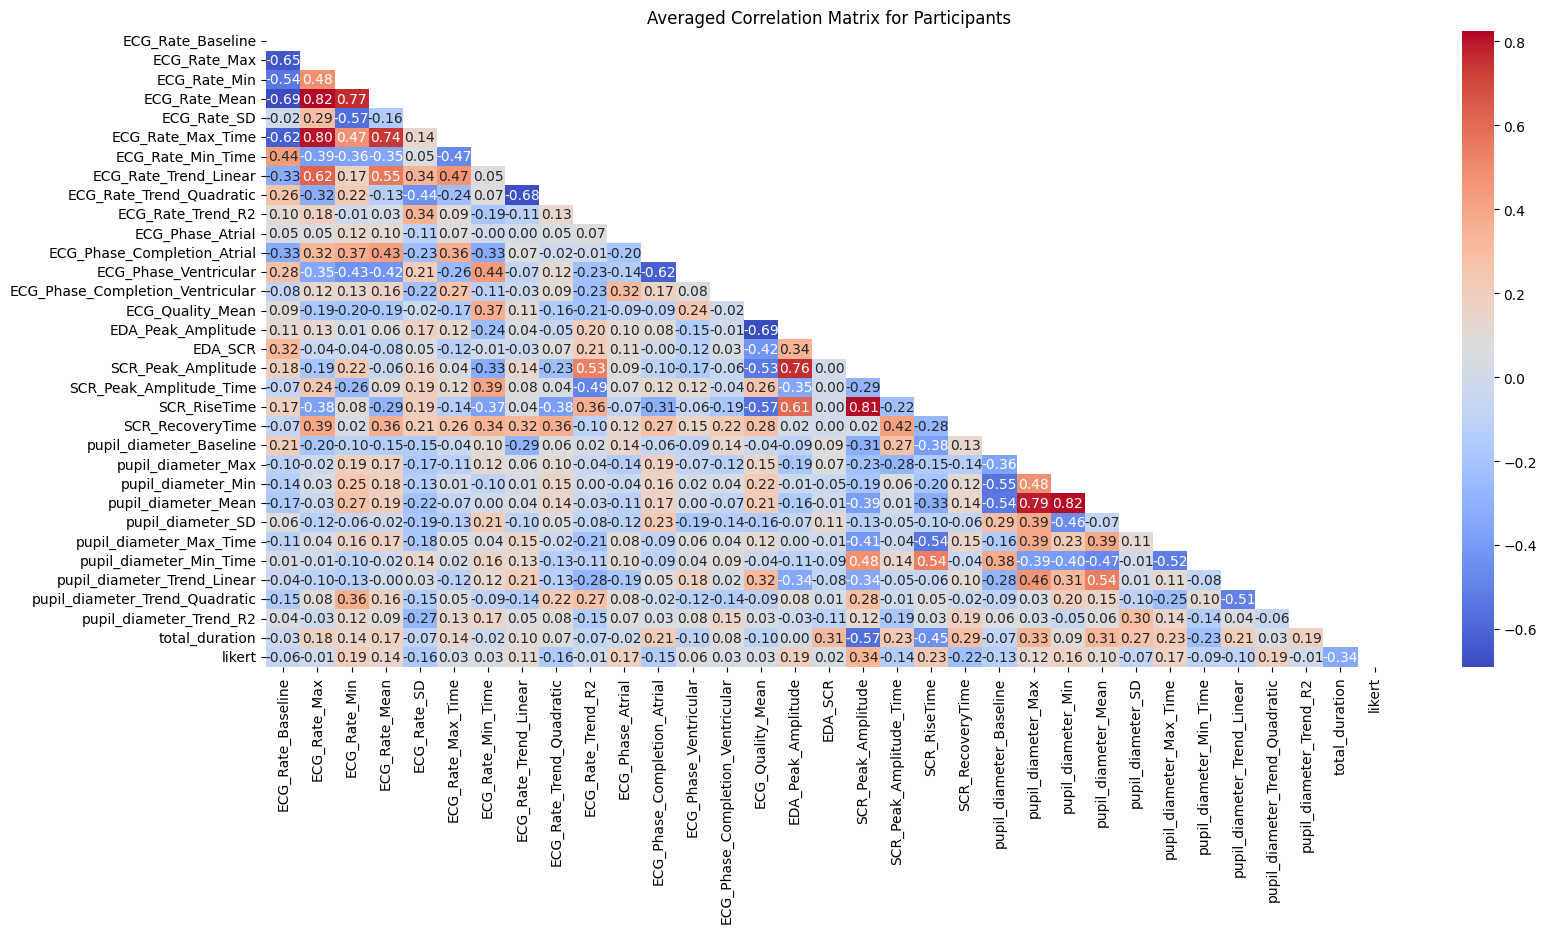

In [12]:
correlation_matrices = []
for subject, data in df.groupby('subject', sort=False):
    data = data.drop(columns='subject')
    correlation_matrix = data.corr()
    correlation_matrices.append(correlation_matrix)

average_correlation_matrix = pd.concat(correlation_matrices).groupby(level=0, sort=False).sum() / len(correlation_matrices)
plot_correlation_matrix(average_correlation_matrix, title="Averaged Correlation Matrix for Participants")

#### EDA Analysis

In [13]:
# EDA Analysis per Participant
# For how many of the participants is the SCR_Peaks_Apmplitude_Mean inside the epochs higher than for the total interval?

# Get SCR_Peaks_Amplitude_Mean during epochs for each participant
eda_peaks_mean = df.groupby('subject')['SCR_Peak_Amplitude'].mean()

# Get SCR_Peaks_Amplitude_Mean for the total interval
eda_peaks_mean_interval = interval_df['SCR_Peaks_Amplitude_Mean']

print(f"Number of participants with higher mean EDA peak amplitude during epochs than in total interval: {sum(eda_peaks_mean > eda_peaks_mean_interval)}")

Number of participants with higher mean EDA peak amplitude during epochs than in total interval: 6


In [14]:
# EDA Analysis per Event
scr_peak_amplitude_dfs = []
for subject in df['subject'].unique():
    scr_peak_amplitude  = df[df['subject'] == subject]['SCR_Peak_Amplitude']
    scr_peak_amplitude = scr_peak_amplitude.to_frame()
    scr_peak_amplitude['SCR_Peak_Amplitude_Divided'] = scr_peak_amplitude['SCR_Peak_Amplitude'] / interval_df['SCR_Peaks_Amplitude_Mean'][subject]
    scr_peak_amplitude['likert'] = df[df['subject'] == subject]['likert']
    scr_peak_amplitude_dfs.append(scr_peak_amplitude)

scr_peak_amplitude = pd.concat(scr_peak_amplitude_dfs)

for event in scr_peak_amplitude.index.unique():
    filtered_by_event = scr_peak_amplitude[scr_peak_amplitude.index == event]
    print(f"Event: {event}")
    print(f"{filtered_by_event['SCR_Peak_Amplitude'].count()} participants had a skin conductance response during the {event} event.")
    correlation1 = filtered_by_event['SCR_Peak_Amplitude'].corr(filtered_by_event['likert'])
    print(f"Correlation between SCR peak amplitude during the event and corresponding likert score:\t\t\t\t\t\t  {correlation1}")
    correlation2 = filtered_by_event['SCR_Peak_Amplitude_Divided'].corr(filtered_by_event['likert'])
    print(f"Correlation between SCR peak amplitude quotient during the event and interval and corresponding Likert score: {correlation2}")
    print()

Event: cookies
5 participants had a skin conductance response during the cookies event.
Correlation between SCR peak amplitude during the event and corresponding likert score:						  -0.652999060116572
Correlation between SCR peak amplitude quotient during the event and interval and corresponding Likert score: -0.13082300578895806

Event: geolocation
4 participants had a skin conductance response during the geolocation event.
Correlation between SCR peak amplitude during the event and corresponding likert score:						  0.7404852951946762
Correlation between SCR peak amplitude quotient during the event and interval and corresponding Likert score: -0.8019517242270834

Event: confirmshaming
3 participants had a skin conductance response during the confirmshaming event.
Correlation between SCR peak amplitude during the event and corresponding likert score:						  0.3721742247973146
Correlation between SCR peak amplitude quotient during the event and interval and corresponding Likert score:

#### ECG Analysis

In [15]:
# ECG Analysis per Participant
# For how many of the participants is the mean heart rate inside the epochs higher than for the total interval?

# Get mean heart rate during epochs for each participant
modified_df = df.copy()
modified_df['ECG_Rate_Mean'] += modified_df['ECG_Rate_Baseline']
mean_heart_rate = modified_df.groupby('subject')['ECG_Rate_Mean'].mean()

# Get mean heart rate for the total interval
mean_heart_rate_interval = interval_df['ECG_Rate_Mean']

print(f"Number of participants with higher mean heart rate during epochs than in total interval: {sum(mean_heart_rate > mean_heart_rate_interval)}")

Number of participants with higher mean heart rate during epochs than in total interval: 5


In [16]:
# ECG Analysis per Event
mean_heart_rate_dfs = []
for subject in df['subject'].unique():
    mean_heart_rate = modified_df[modified_df['subject'] == subject]['ECG_Rate_Baseline']
    mean_heart_rate = mean_heart_rate.to_frame()
    mean_heart_rate['ECG_Rate_Baseline'] -= interval_df['ECG_Rate_Mean'][subject]
    mean_heart_rate['likert'] = df[df['subject'] == subject]['likert']
    mean_heart_rate_dfs.append(mean_heart_rate)

mean_heart_rate = pd.concat(mean_heart_rate_dfs) 

for event in mean_heart_rate.index.unique():
    filtered_by_event = mean_heart_rate[mean_heart_rate.index == event]
    print(f"Event: {event}")
    print(f"{sum(filtered_by_event['ECG_Rate_Baseline'] > 0)} participants had a higher mean heart rate during the {event} event.")
    correlation = filtered_by_event['ECG_Rate_Baseline'].corr(filtered_by_event['likert'])
    print(f"Correlation between mean heart rate increase during the event and interval and corresponding Likert score: {correlation}")
    print()

Event: cookies
6 participants had a higher mean heart rate during the cookies event.
Correlation between mean heart rate increase during the event and interval and corresponding Likert score: -0.6403647119964541

Event: geolocation
5 participants had a higher mean heart rate during the geolocation event.
Correlation between mean heart rate increase during the event and interval and corresponding Likert score: -0.25462809542099174

Event: confirmshaming
3 participants had a higher mean heart rate during the confirmshaming event.
Correlation between mean heart rate increase during the event and interval and corresponding Likert score: 0.5512002962158358

Event: personalDetails
5 participants had a higher mean heart rate during the personalDetails event.
Correlation between mean heart rate increase during the event and interval and corresponding Likert score: 0.4896534847787079

Event: confusingCheckbox
3 participants had a higher mean heart rate during the confusingCheckbox event.
Correl